In [362]:
import os, json, glob, requests, spotipy
from math import ceil
import pandas as pd
from pandas.io.json import json_normalize
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy.util as util
from datetime import datetime
from textwrap import wrap

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

pd.set_option('display.max_columns', None)

In [379]:
########## 1. read in data ############

#load data
path = os.getcwd()
path_to_json = f'{path}/MyData'

#read data
json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json') and pos_json.startswith('StreamingHistory')]

#here I define my pandas Dataframe with the columns I want to get from the json
jsons_data = pd.DataFrame(columns=['endTime', 'artistName', 'trackName', 'msPlayed'])

endTime_list = []
artistName_list = []
trackName_list = []
msPlayed_list = []
        
for index, js in enumerate(json_files):
    with open(os.path.join(path_to_json, js)) as json_file:
        json_text = json.load(json_file)
    
    #get each column
    for i in range(0, len(json_text)):
        endTime = json_text[i]['endTime']
        artistName = json_text[i]['artistName'].replace('$', 'S')
        trackName = json_text[i]['trackName'].replace('$', 'S')
        msPlayed = json_text[i]['msPlayed']
           
        endTime_list.append(endTime)
        artistName_list.append(artistName)
        trackName_list.append(trackName)
        msPlayed_list.append(msPlayed)

#store in pd dataframe
d = {'endTime':endTime_list,'artistName':artistName_list,
    'trackName':trackName_list,'msPlayed':msPlayed_list}        
dataf = pd.DataFrame(d)


######### Create monthly and weekly divisions #########
df = dataf.copy()
df['month'] = pd.to_datetime(df['endTime']).dt.to_period('M')
df['week'] = pd.to_datetime(df['endTime']).dt.to_period('W')

print(df.shape)
df.head()


(67290, 6)


,endTime,artistName,trackName,msPlayed,month,week
0,2020-07-31 03:03,Juan D'Arienzo,La cumparsita,4806,2020-07,2020-07-27/2020-08-02
1,2020-07-31 03:03,azul azul,La Bomba,2937,2020-07,2020-07-27/2020-08-02
2,2020-07-31 03:03,Buya,Yo No Tengo Si Te Preguntaran (Guembe Corrido)...,8893,2020-07,2020-07-27/2020-08-02
3,2020-07-31 03:03,Buya,Lah Tere (Live),6153,2020-07,2020-07-27/2020-08-02
4,2020-07-31 03:04,Dillon Francis,Touch - Jaded Remix,4899,2020-07,2020-07-27/2020-08-02


In [380]:
###########################################
################## DATA WRANGLING #################
###########################################
#Parameters
ARTIST_TOP_NO_MONTH = 3
ARTIST_TOP_NO_WEEK = 5
TRACK_TOP_NO_MONTH = 5
TRACK_TOP_NO_WEEK = 5

######### How many per time period ##########
def top_no(column, period):
    if column =='artist':
        if period == 'month':
            return ARTIST_TOP_NO_MONTH
        elif period == 'week':
            return ARTIST_TOP_NO_WEEK
    elif column == 'track':
        if period == 'month':
            return TRACK_TOP_NO_MONTH
        if period == 'week':
            return TRACK_TOP_NO_WEEK

#iteratively create correct dataframes given column (artist or track) and period (month, week)
d = {}
column_dict = {}
period_dict = {}
for column in ['artist', 'track']:
    for period in ['month', 'week']:
        dff = df.groupby([f'{period}', f'{column}Name'], as_index=False).sum()
        dff.sort_values([f'{period}', 'msPlayed'], ascending=[True, False], inplace=True)
        dff = dff.groupby([f'{period}']).head(top_no(f'{column}', f'{period}'))
        dff['rank'] = dff.groupby(f'{period}')['msPlayed'].rank(method='max', ascending=False)
        dff.reset_index(drop=True, inplace=True)

        #store in d
        d[f'{column}_{period}'] = dff
        
        #store column and period in their own dicts
        column_dict[f'{column}_{period}'] = column
        period_dict[f'{column}_{period}'] = period
    

In [381]:
print(column_dict)

{'artist_month': 'artist', 'artist_week': 'artist', 'track_month': 'track', 'track_week': 'track'}


In [391]:
#change if I want to just run a subset of the four
#d_list = ['artist_month','artist_week','track_month','track_week']
dl = ['artist_month','artist_week','track_month','track_week']

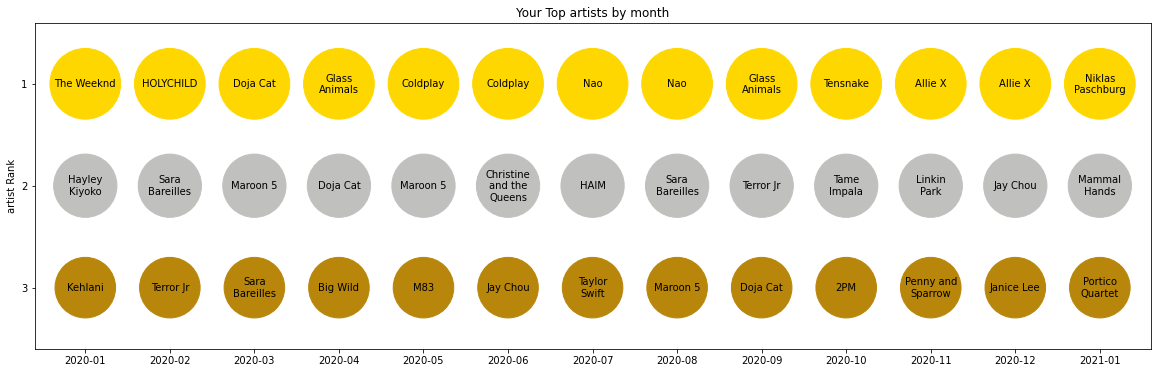

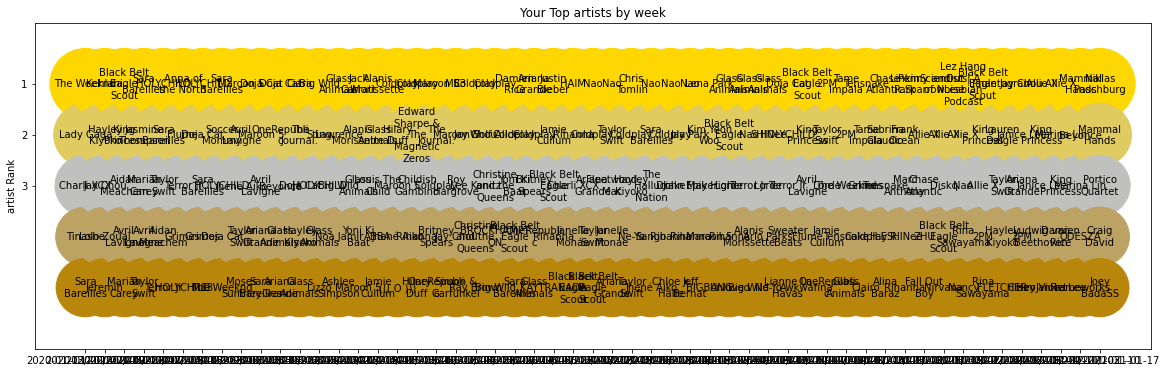

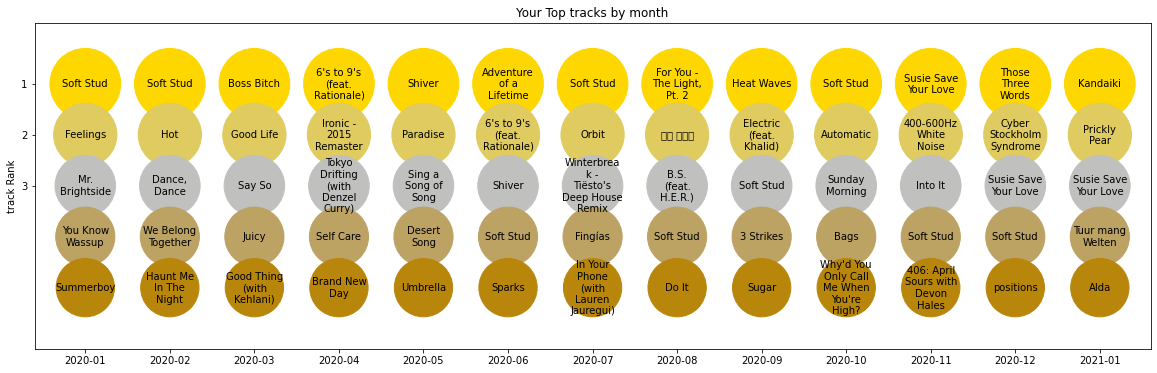

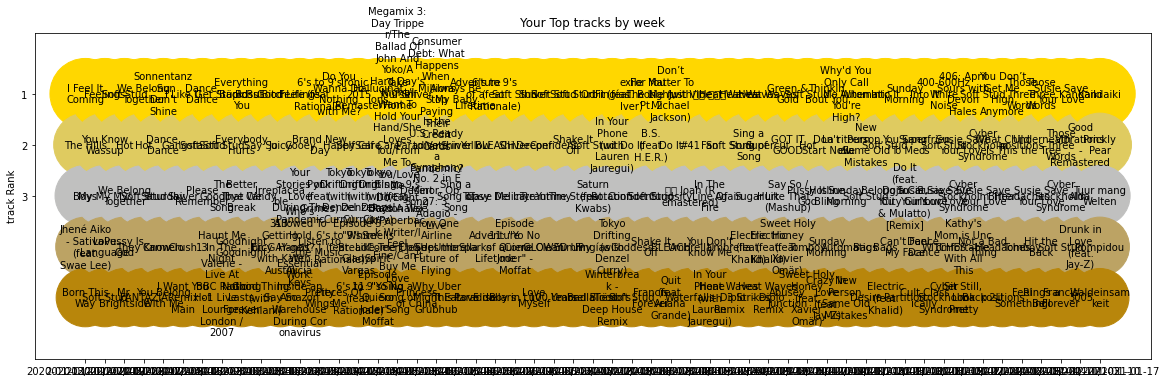

In [392]:
######### Visualize ##########

for ds in dl:
    column = column_dict.get(ds)
    nameType = f'{column}Name'
    period = period_dict.get(ds)
    df = d.get(ds)
    names = df[nameType].to_list()
    df[period] = df[period].astype(str)
    
    x = df[period].to_list()
    y = df['rank'].to_list()

    fig, ax = plt.subplots()

    fig.set_size_inches(20, 6)
    ax.invert_yaxis()
    plt.yticks([1,2,3])

    #adjust margins
    plt.margins(0.05, 0.3)

    ax.set_ylabel(f'{column} Rank')
    ax.set_title(f'Your Top {column}s by {period}')

    #set size of medal
    rank = df['rank']
    rank_size = 2000/rank + 3000

    #color each medal by rank
    cmap = LinearSegmentedColormap.from_list('mycmap', ['gold', 'silver', 'darkgoldenrod'])

    ax.scatter(x, y, s=rank_size, c=rank, cmap=cmap)
    
    names_label = [ '\n'.join(wrap(l, 10)) for l in names]
    
    for i, txt in enumerate(names_label):
        ax.annotate(txt, (x[i], y[i]), ha='center', va='center')

plt.show()